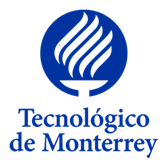

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 4

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Configuración la Base de Conocimiento y el Modelo Fundacional**

<img src="./Proyecto Integrador - RAG con Bedrock-Smart Travel Assistant KB v2.00 LangChain.drawio.png" alt="RAG Bedrock KB V1.00" />

Para crear el modelo de referencia para este proyecto se creo una base de datos de conocimientos en **AWS Bedrock**. El proceso es el siguiente:
1. Crear la base de conocimientos, o **Knowledge Base**. Para este proyecto la base de conocimiento se llama *Volindo-hotels* y se usa una base de datos de vectores de **Pinecone**
> * La fuente de conocimiento incluye más de 160 mil pares de archivos de texto y JSON con los datos de más de 145,000 hoteles. Cada par de archivos representa un hotel.
2. Cargar los datos en un Bucket de S3, llamado *hotel-clean-data*
3. Asociar el Bucket de S3 como una fuente de información para la base de conocimiento
4. Sincronizar (cargar) los datos de la fuente de información

Una vez cargado la base de conocimiento se puede probar usando la consola de AWS Bedrock o a través de APIs, tal y como se hará a continuación.

## **Probando la Base de Conocimiento y el Modelo Fundacional**

### **Preparando el Ambiente de Ejecución**

Es necesario importar las librerías necesarias para iniciar una sesión de AWS y para registrar una bitácora de ejecución.

In [ ]:
!pip install langchain

In [ ]:
!pip install langchain-community

In [ ]:
!pip install langchain-text-splitters

In [ ]:
!pip install langchain-aws

In [ ]:
!pip install pinecone-client

In [ ]:
!pip install pip install renumics-spotlight

In [2]:
# Importando librerias requeridas
import time
import re
import json
import uuid
import io
import logging
import os

from dotenv import load_dotenv
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import boto3

from langchain_community.retrievers import AmazonKnowledgeBasesRetriever
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.embeddings import BedrockEmbeddings
from langchain_aws import BedrockLLM

from pinecone import Pinecone
from renumics import spotlight

In [3]:
# Creado manejador de bitácora
logger = logging.getLogger(__name__)
#logging.basicConfig(
#    filename='../logs/Avance4_Equipo37_Bedrock_Alternative.log',
#    level=logging.INFO,
#    format='%(asctime)s %(levelname)-8s %(message)s',
#    datefmt='%Y-%m-%d %H:%M:%S'
#)

In [4]:
# Configurando constantes para la ejecución. AWS_KBID_Vxxx contiene el identificador de la base
# de conocimientos de AWS Bedrock
load_dotenv()
LOCAL_SET = '../local-responses'
AWS_KBID_V100 = os.environ['AWS_KBID_V100']
AWS_KBID_V200 = os.environ['AWS_KBID_V200']
PINECONE_API_KEY_V100 = os.environ['PINECONE_API_KEY_V100']
PINECONE_API_KEY_V200 = os.environ['PINECONE_API_KEY_V200']

5XNHOMTE5G DT9APRDIVV 9d387e08-bf11-4e53-851e-429ba194d807 6c70ed92-a277-4a64-8188-163e20b6bfca


### **Evaluando la Base de Conocimiento y el Modelo Fundacional**

AWS Bedrock provee tres tipos de mecanismos para evaluar el desempeño de los modelos fundacionales:
* Evaluación automatizada
* Evaluación por un equipo de humanos
* Evaluación por un servicio de evaluación de AWS

La evaluación automatizada permite hacer evaluaciones de la precisión del modelo, la toxicidad de las respuestas y la robustes de las respuestas. Desafortunadamente AWS solo ofrece este servicio para solo uno de los modelos de Amazon y no cubre la evaluación de la base de conocimiento y de las respuestas generadas en combinación con el modelo fundacional de Titan Text Premier.

Durante estas pruebas se hará una evaluación cualitativa de las repuestas. Para este efecto cada participante del equipo proveerá una calificación de la respuesta indicando si la respuesta es o no correcta, si es precisa o imprecisa y si está o no basada en los hechos de referencia. La calificación se evalúa en una escala del 1 al 5 como sigue  (Grech, 2024):

1. La respuesta es completamente incorrecta, imprecisa y/o no basada en los hechos
2. La respuesta es en su mayoría incorrecta, imprecisa y/o no basada en los hechos
3. La respuesta es de alguna manera correcta, precisa y/o basada en los hechos
4. La respuesta es en su mayoría correcta, precisa y/o basada en los hechos
5. La respuesta es completamente correcta, precisa y/o basada en los hechos


### **Creando Agente para Recuperar Informacion de Contexto**

In [6]:
# Creando clientes para componentes de AWS Bedrock. Credenciales y configuracion se obtienen de ~/.aws
retriever_v100 = AmazonKnowledgeBasesRetriever(
    knowledge_base_id=AWS_KBID_V100,
    retrieval_config={'vectorSearchConfiguration': {'numberOfResults': 10}},
)
retriever_v200 = AmazonKnowledgeBasesRetriever(
    knowledge_base_id=AWS_KBID_V200,
    retrieval_config={'vectorSearchConfiguration': {'numberOfResults': 10}},
)
embeddings = BedrockEmbeddings(model_id='amazon.titan-embed-text-v1')

### **Creando Agente para Questionar el Modelo Fundacional**

In [7]:
model_kwargs_premier = {'temperature': 0, 'topP': 0.7, 'maxTokenCount': 3000}
llm = BedrockLLM(model_id='amazon.titan-text-premier-v1:0', model_kwargs=model_kwargs_premier)

### **Creando Agentes para Questionar Base de Datos de Vectores**

In [8]:
pc_v100 = Pinecone(api_key=PINECONE_API_KEY_V100)
pc_v200 = Pinecone(api_key=PINECONE_API_KEY_V200)

### **Creando Función para Solictar Respuestas de AWS Bedrock y para Desplegarlas**

In [9]:
# Creando función para buscar información en la base de conocimiento y generar una respuesta usando el modelo fundacional
# Titan Text Premier de AWS Bedrock. La función también calcula el tiempo de ejecución
def retrieve_and_generate(query, retriever, llm):
    start_time = time.time()
    system_prompt = (
        "You are a friendly and helpful travel assistant. Begin your response with a polite greeting. Accurately use the detailed context provided from the database "
        "to answer the following query, particularly focusing on correct location details. Ensure the locations mentioned are verified against "
        "the context. Provide options within the same city or nearby, double-checking location accuracy. Offer two or three choices when possible. "
        "Address the user by name if provided in the context. If the answer is unknown or if you cannot verify the location details, state 'I don't know'. "
        "Limit responses to three sentences and maintain conciseness. "
        "Context: {context}"
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )
    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    chain = create_retrieval_chain(retriever, question_answer_chain)
    
    response = chain.invoke({"input": query})
    elapsed_time = time.time() - start_time
    return elapsed_time, response


In [10]:
# Creando función desplegar la respuesta recibida de AWS. La respuesta incluye diferentes valores como la respuesta completa,
# la respuesta en partes, o citas, con referencias y los metadatos de cada referencia
def display_response(response, elapsed_time):
    # desplegando respuestas
    print(f"Respuesta despues de {elapsed_time:.4f} segundos:\n{response['answer']}")
#    for context in response['context']:
#        print(f"\nContexto:\n{context.page_content}")
#        print(f"\nCalificacion:{context.metadata['score']:.6f}")
#        print(f"\nNombre del hotel: {context.metadata['source_metadata']['Name']}, Ciudad:{context.metadata['source_metadata']['City']}, Direccion:{context.metadata['source_metadata']['Address']}")
#        print(f"\nPais: {context.metadata['source_metadata']['Country']}, Continente:{context.metadata['source_metadata']['Continent']}, URI:{context.metadata['source_metadata']['x-amz-bedrock-kb-source-uri']}")


In [14]:
input = '''Can you suggest accomodation near pilanesberg national park in south africa?'''
in_emb = embeddings.embed_query(input)
index = pc_v200.Index('volindov200')
emb_space = index.query(
    vector=in_emb,
    top_k=10,
    include_values=True,
    include_metadata=True,
    filter={
        "City": {"$eq": 'Pilanesberg'}
    }
)
emb_space

{'matches': [{'id': 'a65ce05b-e8e0-441f-b6ad-b80433f7f71f',
              'metadata': {'Address': 'bakgatla gate pilanesberg national park '
                                      '318, close to sun citypilanesberg '
                                      'national parkpilanesberg game reserve, '
                                      'pilanesberg, 0316, south africa',
                           'City': 'Pilanesberg',
                           'Code': '1087750',
                           'Continent': 'Africa',
                           'Country': 'South Africa',
                           'CountryCode': 'ZA',
                           'Latitude': -25.186032,
                           'Longitude': 27.144907,
                           'Name': 'ivory tree game lodge',
                           'Rating': 5.0,
                           'hotel-data': 'HeadLine : In a national '
                                         'parkLocation : When you stay at '
                                  

In [ ]:
def visualize_space(input, response, city, index_name, pc):
    in_emb = embeddings.embed_query(input)
    out_emb = embeddings.embed_query(response)

    index = pc.Index(index_name)
    emb_space = index.query(
        vector=in_emb,
        top_k=10,
        include_values=True,
        include_metadata=True,
        filter={
        "City": {"$eq": city}
    )

    emb_space_df = pd.DataFrame(
        {
            "id": emb_space["id"],
            "source": [metadata.get("source") for metadata in response["metadatas"]],
            "page": [metadata.get("page", -1) for metadata in response["metadatas"]],
            "document": response["documents"],
            "embedding": response["embeddings"],
        }
    )

### **Ejecutando la Evaluación**

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''Can you suggest accomodation near pilanesberg national park in south africa?'''

elapsed_time_v100, response_v100 = retrieve_and_generate(input, retriever_v100, llm)
display_response(response_v100, elapsed_time_v100)

elapsed_time_v200, response_v200 = retrieve_and_generate(input, retriever_v200, llm)
display_response(response_v200, elapsed_time_v200)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''Can you suggest accomodation near pilanesberg national park in the north west province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''What attractions are close to Black Rhino Game Lodge, north west province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 4 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa, minimum rating of 4?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''Can you suggest accommodation in Hoedspruit, limpopo province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 1 |
| JC Alvarado | 1 |
| JC Romo | 2 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico, near Tec de Monterrey?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''I want to stay with my wife for a romantic weekend in Mexico City. We want to have a nice massage within the hotel.'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 4 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''I want to do a a golf weekend with my friends in Cancun. What hotels do you recommend that have their own golf course?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 4 |
| JC Alvarado | 4 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''Can you recommend hotels near Ueno Park in Tokyo?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 4 |
| JC Alvarado | 5|
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''Can you recommend hotels in Hakone Japan? Ideally I am looking for traditional japanese ryokans.'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [ ]:
input = '''Can you recommend hotels in Chihuauha that are located near Periferico de la Juventud?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 2 |
| JC Alvarado | 4 |
| JC Romo | 3 |

## **Conclusiones**


El análisis de la evaluación se encuentra en el archivo ***Proyecto-Integrador-Evaluacion-Avance4.xlsx*** en el mismo repositorio de esta libreta.

La presentación de los nuevos modelos y la selección del mejor modelo se encuentran en el archivo ***Avance4 Smart Travel Assistant-Reporte de Progreso-02.pptx*** en el mismo repositorio de esta libreta.

## **Referencias**

* Monigatti, L. (2023, 6 de diciembre). A Guide on 12 Tuning Strategies for Production-Ready RAG Applications. Medium. https://towardsdatascience.com/a-guide-on-12-tuning-strategies-for-production-ready-rag-applications-7ca646833439

* AWS. (s.f.). Set up a data source for your knowledge base - Amazon Bedrock. docs.aws.amazon.com. Recuperado 7 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base-ds.html

* AWS. (s.f.). Getting started with model evaluations - Amazon Bedrock. docs.aws.amazon.com. Recuperado 15 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-evaluation-type.html

* AWS. (2023, 28 de noviembre). Knowledge Bases now delivers fully managed RAG experience in Amazon Bedrock - Amazon Web Services.  Amazon Web Services. https://aws.amazon.com/es/blogs/aws/knowledge-bases-now-delivers-fully-managed-rag-experience-in-amazon-bedrock/

* Monigatti, L. (2023, 15 de deciembre). Evaluating RAG Applications with RAGAs. Medium. https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a

* Grech, C. (2024, 16 de febrero). Evaluating RAG Performance: A Comprehensive Guide. Medium. https://christiangrech.medium.com/evaluating-rag-performance-a-comprehensive-guide-b1d8f903b7ad

* AWS (s.f.). Amazon Titan Text models - Amazon Bedrock. docs.aws.amazon.com. Recuperado 20 de mayo 26, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-text.html

* LangChain. (s.f.). Bedrock (Knowledge Bases). python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/retrievers/bedrock/

* LangChain. (s.f.). ChatBedrock. python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/chat/bedrock/

* LangChain. (s.f.). langchain.chains.retrieval_qa.base.RetrievalQA LangChain 0.1.12. api.python.langchain.com. https://api.python.langchain.com/en/latest/chains/langchain.chains.retrieval_qa.base.RetrievalQA.html

